# matlab的手写字母识别程序通过python实现

## 数据预处理
对应preparedata.mlx

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import argrelmax, argrelmin
from sklearn.model_selection import train_test_split

In [2]:
def preprocess(data):
    # Normalize time [0 1]
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    data['Time'] = data[['Time']].apply(max_min_scaler)
    # Fix aspect ratio
    data['X'] = data['X'] * 1.5
    # Center X & Y at (0,0)
    data['X'] = data['X'] - data['X'].mean(skipna=True)
    data['Y'] = data['Y'] - data['Y'].mean(skipna=True)
    #Scale to have bounding box area = 1
    range_x =  data['X'].max() - data['X'].min()
    range_y =  data['Y'].max() - data['Y'].min()
    scl = 1/np.sqrt(range_x*range_y)
    data['X'] = data['X'] *scl
    data['Y'] = data['Y'] *scl
    #Calculate derivatives
    data['dXdT'] =data['X'].diff()/data['Time'].diff()
    data['dYdT'] =data['Y'].diff()/data['Time'].diff()
    data['dXdT'][np.isinf(data['dXdT'])] = np.nan
    data['dYdT'][np.isinf(data['dYdT'])] = np.nan
    #Smooth derivatives using a moving average
    n = round(0.1*len(data))
    data['dXdT'] = data['dXdT'].rolling(window=n,min_periods=1).mean()  #There is a difference with matlab's movmean
    data['dYdT'] = data['dYdT'].rolling(window=n,min_periods=1).mean()
    return data

In [3]:
def local_max_num(data,min_prominence=0):
    # in order to implement matlab's islocalmax and nnz in extractfeatures
    max_set = argrelmax(data)[0]
    ans = 0
    for i in max_set:
        left = right = i
        left_value = data[left]
        right_value = data[right]
        while left>0 and right<len(data)-1:
            left = left -1
            if data[left]<left_value:
                left_value = data[left]
            else:
                break
            right = right+1
            if data[right]<right_value:
                right_value = data[right]
            else:
                break
        local_min = max(left_value,right_value)
        if data[i] - local_min >= min_prominence:
            ans = ans+1
    return ans

def local_min_num(data,min_prominence):
    # in order to implement matlab's islocalmin and nnz in extractfeatures
    min_set = argrelmin(data)[0]
    ans = 0
    for i in min_set:
        left = right = i
        left_value = data[left]
        right_value = data[right]
        while left>0 and right<len(data)-1:
            left = left -1
            if data[left]>left_value:
                left_value = data[left]
            else:
                break
            right = right+1
            if data[right]>right_value:
                right_value = data[right]
            else:
                break
        local_max = min(left_value,right_value)
        if local_max - data[i] >= min_prominence:
            ans = ans+1
    return ans

In [4]:
def extractfeatures(data):
    #Correlations between signals (not including time)
    df = data.drop('Time',axis=1)
    c = df.corr()
    #Set some parameters for finding local mins/maxes
    mp = 0.1
    derivscale = 2
    #Calculate features
    feat = [
        (data['Y'].max() - data['Y'].min())/(data['X'].max() - data['X'].min()),
        data['X'].mad(), data['Y'].mad(),
        data['dXdT'].mean(skipna=True), data['dXdT'].mad(),
        data['dYdT'].mean(skipna=True), data['dYdT'].mad(),
        c.iloc[0,1],c.iloc[0,2],c.iloc[0,3],c.iloc[0,4],
        c.iloc[1,2],c.iloc[1,3],c.iloc[1,4],
        c.iloc[2,3],c.iloc[2,4],
        c.iloc[3,4],
        local_min_num(data['X'].to_numpy(),min_prominence=mp),
        local_max_num(data['X'].to_numpy(),min_prominence=mp),
        local_min_num(data['Y'].to_numpy(),min_prominence=mp),
        local_max_num(data['Y'].to_numpy(),min_prominence=mp),
        local_min_num(data['dXdT'].to_numpy(),min_prominence=mp*derivscale),
        local_max_num(data['dXdT'].to_numpy(),min_prominence=mp*derivscale),
        local_min_num(data['dYdT'].to_numpy(),min_prominence=mp*derivscale),
        local_max_num(data['dYdT'].to_numpy(),min_prominence=mp*derivscale),
    ]
    # Combine features together into a table
    feat_df = pd.DataFrame([feat],columns=["AspectRatio",
        "MADX","MADY","AvgU","MADU","AvgV","MADV",
        "CorrXY","CorrXP","CorrXU","CorrXV",
        "CorrYP","CorrYU","CorrYV","CorrPU","CorrPV","CorrUV",
        "NumXMin","NumXMax","NumYMin","NumYMax",
        "NumUMin","NumUMax","NumVMin","NumVMax"])
    return feat_df

In [5]:
path = "./Data_csv/"
files = os.listdir(path)
df_list = []
for filename in files:
    df = pd.read_csv(os.path.join(path,filename))
    df = preprocess(df) 
    df = extractfeatures(df)
    df['Character'] = filename[-7]
    df_list.append(df)
data = pd.concat(df_list)
data.to_csv("letterdata.csv")
data

,AspectRatio,MADX,MADY,AvgU,MADU,AvgV,MADV,CorrXY,CorrXP,CorrXU,...,CorrUV,NumXMin,NumXMax,NumYMin,NumYMax,NumUMin,NumUMax,NumVMin,NumVMax,Character
0,1.566667,0.155515,0.336314,0.402513,1.207899,-0.736808,3.083448,-0.143943,-0.241944,0.671011,...,0.147013,1,0,1,1,2,1,2,2,A
0,3.679012,0.151472,0.598794,0.087237,0.825915,-1.457384,3.109003,-0.415116,0.467392,0.344747,...,0.339145,0,1,1,1,1,1,3,1,B
0,1.866667,0.223734,0.515179,0.504118,2.014227,-1.131922,1.636434,0.189992,-0.800097,0.588285,...,0.391168,0,0,0,1,1,1,1,0,C
0,2.047619,0.183840,0.312863,0.348707,1.216012,-0.369593,3.378667,0.512999,0.001919,0.481722,...,0.292034,1,0,1,1,2,0,2,1,D
0,1.405405,0.197169,0.315278,0.692642,1.633679,-0.350907,2.033643,-0.111211,-0.334064,0.616372,...,0.136035,1,1,1,1,2,2,1,1,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.436782,0.194104,0.427638,0.474132,1.323923,-1.152140,3.497025,0.395097,-0.086796,0.518056,...,-0.137601,0,0,1,1,2,2,3,1,X
0,3.058824,0.191712,0.505626,0.510032,1.069743,-0.782157,3.791945,-0.357911,0.204132,0.310416,...,0.643397,0,0,2,1,2,1,3,3,Y
0,4.098765,0.168077,0.512924,0.368738,0.905094,-0.813833,4.344719,-0.339293,0.157811,0.362723,...,0.325587,1,0,2,1,1,2,2,2,Y
0,1.500000,0.245132,0.292555,1.745557,2.524521,-0.563572,2.723824,-0.064039,0.057375,0.791365,...,0.672700,1,0,1,0,1,3,3,3,Z


In [6]:
letterdata = pd.read_csv("letterdata.csv")
letterdata.drop(columns='Unnamed: 0',inplace=True)
X_train, X_test, y_train, y_test = train_test_split(letterdata.iloc[:, :-1], letterdata.iloc[:, -1], 
test_size=0.25, random_state=123)

# 模型训练
对应lettermodels.mlx

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [8]:
def plot_cm(model, y_true, y_pred):
    """画混淆矩阵
    :param model: 分类模型
    :param y_true: 标签实际值
    :param y_pred: 标签预测值
    :param name: 模型名称
    """
    _, ax = plt.subplots()
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)
    plt.show()
    return None

#### Try a simple kNN

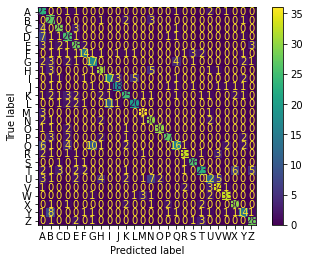

acc =  0.6676986584107327


In [12]:
KNNmodel = KNeighborsClassifier(n_neighbors=5)
KNNmodel.fit(X_train,y_train)
prediction = KNNmodel.predict(X_test)
#plot confusion matrix
plot_cm(KNNmodel,y_test,prediction)
model_acc = accuracy_score(y_test,prediction)
print("acc = ",model_acc)

#### Try more neighbors. Because kNN is distance-based, add normalization.

In [13]:
KNNmodel = KNeighborsClassifier(n_neighbors=10)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale, X_test_scale = scaler.transform(X_train), scaler.transform(X_test)
KNNmodel.fit(X_train_scale, y_train)
prediction = KNNmodel.predict(X_test_scale)
model_acc = accuracy_score(y_test,prediction)
print("acc = ",model_acc)

acc =  0.7729618163054696


#### Try a different number of neighbors but add weighting by distance.

In [14]:
KNNmodel = KNeighborsClassifier(n_neighbors=5,weights='distance')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale, X_test_scale = scaler.transform(X_train), scaler.transform(X_test)
KNNmodel.fit(X_train_scale, y_train)
prediction = KNNmodel.predict(X_test_scale)
model_acc = accuracy_score(y_test,prediction)
print("acc = ",model_acc)

acc =  0.7760577915376677


#### Try a different approach: an ensemble of bagged trees.

In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cart = DecisionTreeClassifier()
num_trees = 30
TBmodel = BaggingClassifier(base_estimator = cart, n_estimators = num_trees, random_state = 12)
TBmodel.fit(X_train,y_train)
prediction = TBmodel.predict(X_test)
model_acc = accuracy_score(y_test,prediction)
print("acc = ",model_acc)

acc =  0.7770897832817337


#### Looks like that's about as good as it's going to get. Go back to the weighted kNN model with k = 5.

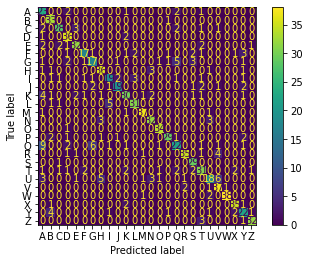

acc =  0.7760577915376677


In [35]:
KNNmodel = KNeighborsClassifier(n_neighbors=5,weights='distance')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale, X_test_scale = scaler.transform(X_train), scaler.transform(X_test)
KNNmodel.fit(X_train_scale, y_train)
prediction = KNNmodel.predict(X_test_scale)
model_acc = accuracy_score(y_test,prediction)
plot_cm(KNNmodel,y_test,prediction)
print("acc = ",model_acc)

## Analyze misclassifications
#### Get the confusion matrix data.

In [43]:
cm = confusion_matrix(y_test, prediction)
yes = np.diag(cm)
no = cm - np.diag(yes)

#### Get misclassification rate for each letter.

In [112]:
misratebyletter = np.sum(no, axis=1)/np.sum(cm, axis=1)

#### Convert to a table with letter names and misclassification rate.

<BarContainer object of 26 artists>

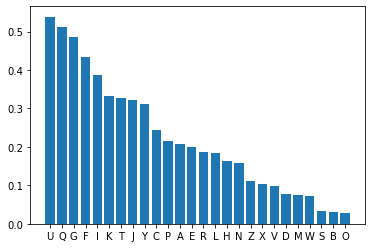

In [184]:
letters = list(set(y_train))
letters.sort()
letters = np.array(letters,dtype=str)
data = np.hstack((letters.reshape(-1,1),misratebyletter.reshape(-1,1)))
misrate_by_letter = pd.DataFrame(data,columns=['Letter','MisClassRate'])
misrate_by_letter['MisClassRate']= misrate_by_letter['MisClassRate'].apply(lambda x: float(x))
# Sort by worst misclassification
misrate_by_letter.sort_values(by="MisClassRate" , inplace=True, ascending=False) 
plt.bar(x=misrate_by_letter['Letter'],height=misrate_by_letter['MisClassRate'])

#### Look at individual misclassification examples.

In [234]:
letter = "U"
# Get the observations with this true class that were misclassified as something else.
misclassidx = (y_test == letter) & (prediction != y_test)
# Make a table of the misclassified observations, with the predicted letter included.
badpred = X_test[misclassidx]
badpred.insert(loc=len(badpred.columns), column='Character', value=y_test[misclassidx])
badpred.insert(loc=len(badpred.columns), column='Prediction', value=prediction[misclassidx])
badpred

,AspectRatio,MADX,MADY,AvgU,MADU,AvgV,MADV,CorrXY,CorrXP,CorrXU,...,NumXMin,NumXMax,NumYMin,NumYMax,NumUMin,NumUMax,NumVMin,NumVMax,Character,Prediction
2927,0.842767,0.282426,0.180516,1.262290,1.380858,-0.206954,1.767951,-0.122733,-0.201827,0.411712,...,1,1,1,1,1,2,2,1,U,E
1185,1.253731,0.246762,0.362779,0.788402,0.770752,-0.614163,2.824256,-0.190669,0.164912,0.650559,...,0,0,2,1,2,1,2,1,U,N
2510,1.066667,0.328617,0.323993,0.978478,0.757430,-0.825773,2.420458,-0.249667,0.024695,0.614693,...,0,0,0,1,2,2,2,1,U,H
2719,0.701149,0.323785,0.247360,1.452050,0.859547,0.838949,2.485869,0.324671,0.313422,-0.079110,...,0,0,1,1,2,3,2,2,U,R
2276,2.088889,0.270994,0.454218,0.744398,0.915206,0.205057,3.164024,-0.000205,0.497131,0.147756,...,0,0,0,0,0,1,1,1,U,V
846,1.154472,0.252969,0.335299,0.843672,0.816340,-1.362618,3.155965,-0.576496,0.369943,0.784003,...,0,0,1,2,1,2,3,2,U,M
550,1.714286,0.221088,0.441054,1.053346,0.769677,-1.357054,2.298611,-0.771021,0.126631,-0.103596,...,0,0,1,1,2,2,2,2,U,H
222,0.845528,0.366333,0.266552,1.017184,1.387047,-1.434201,2.210264,-0.437190,-0.361158,0.555803,...,0,0,0,1,3,3,3,2,U,H
3550,1.460317,0.310379,0.334866,0.902247,0.909515,0.303871,2.362496,0.099991,0.402429,0.103120,...,0,0,1,0,3,2,1,1,U,V
1678,1.565217,0.297024,0.375036,0.122150,1.493869,-0.836086,3.158864,-0.290211,-0.204903,0.541237,...,0,0,1,0,1,1,1,1,U,V


#### Get the associated data files. Read the raw data from each file and plot it. Label the plot with the prediction.

In [235]:
path = "./Data_csv/"
files = os.listdir(path)
badindexes = badpred.index.to_list()
badfiles = []
for badindex in badindexes:
    badfiles.append(files[badindex])
badfiles

['user069_U_2.csv',
 'user031_U_2.csv',
 'user059_U_1.csv',
 'user063_U_2.csv',
 'user055_U_1.csv',
 'user024_U_1.csv',
 'user019_U_3.csv',
 'user007_U_1.csv',
 'user081_U_1.csv',
 'user041_U_1.csv',
 'user079_U_2.csv',
 'user032_U_2.csv',
 'user035_U_1.csv',
 'user049_U_1.csv',
 'user038_U_1.csv',
 'user038_U_2.csv',
 'user085_U_1.csv',
 'user069_U_1.csv',
 'user073_U_1.csv',
 'user059_U_2.csv',
 'user070_U_2.csv']

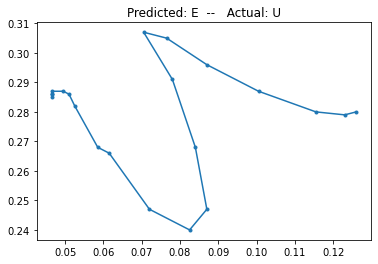

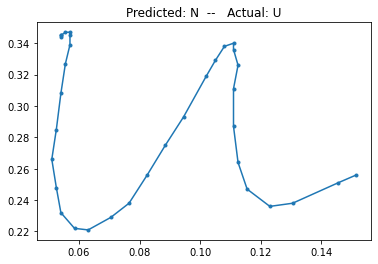

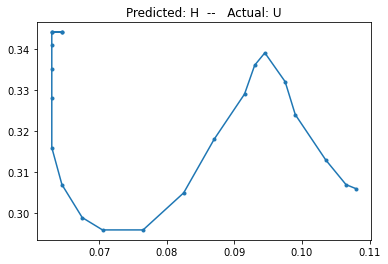

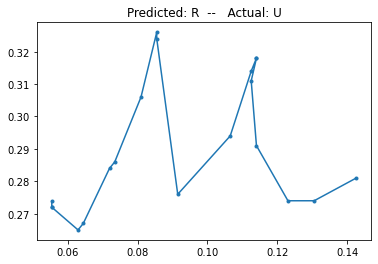

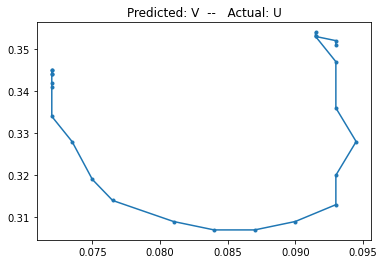

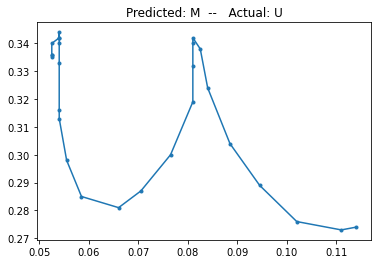

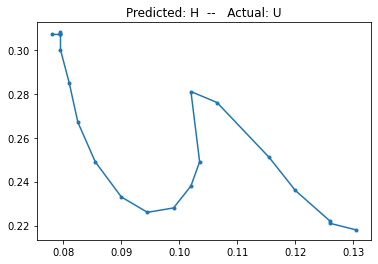

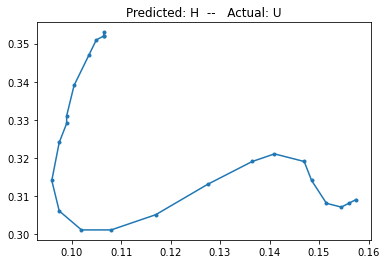

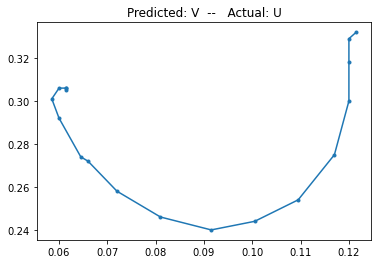

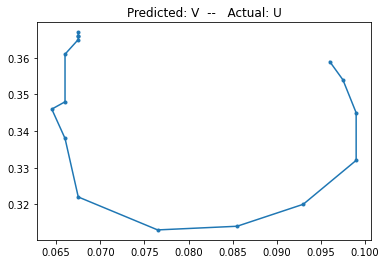

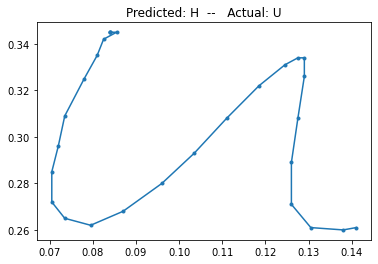

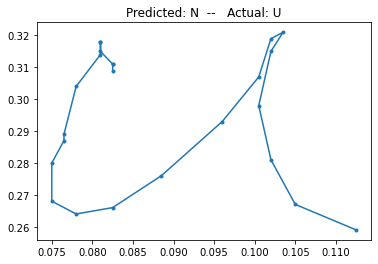

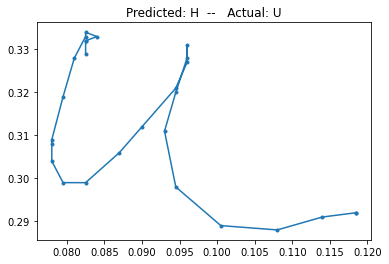

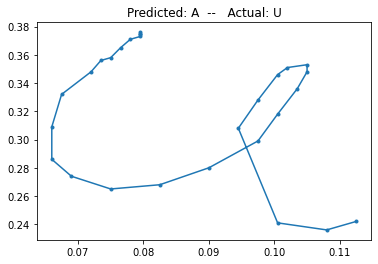

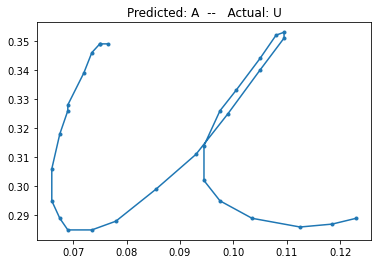

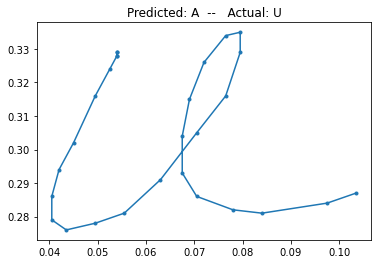

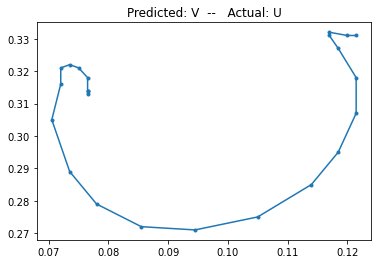

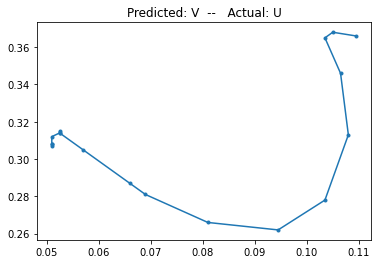

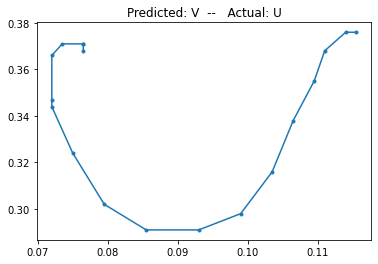

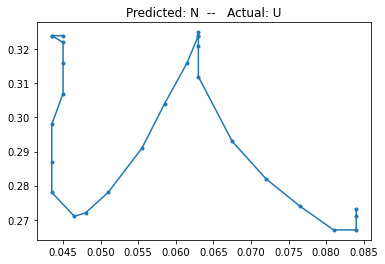

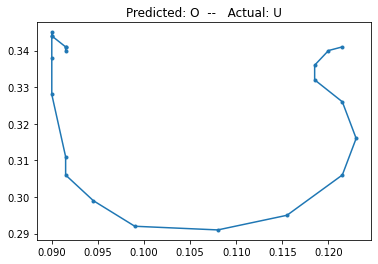

In [236]:
k=0
for badfile in badfiles:
    badfile = badfiles[k]
    df = pd.read_csv(os.path.join(path,badfile))
    plt.plot(1.5*df['X'],df['Y'],".-")
    plt.title("Predicted: "+badpred.iloc[k,:].Prediction+"  --   Actual: "+badpred.iloc[k,:].Character)
    plt.show()
    k=k+1